# 05 - EDA y Modelado: Regresión Mensual de Delitos

## Descripción del Dataset
Dataset mensual para regresión con **60 variables** incluyendo:
- **Lags temporales**: lag_1, lag_3, lag_12 (valores de meses anteriores)
- **Rolling windows**: roll_mean_3/12, roll_std_3/12 (medias y desviaciones móviles)
- **Estacionalidad**: mes_sin, mes_cos (codificación cíclica del mes)
- **Tendencias**: pct_change_1/3/12 (cambios porcentuales)
- **Tasas por 100k hab**: tasa_abigeato, tasa_homicidios, etc.
- **Variables demográficas**: población, densidad, proporciones por edad

## Objetivos de Regresión
1. **Predicción del número exacto de delitos** del próximo mes por municipio
2. **Identificación de variables explicativas** de la fluctuación mensual
3. **Análisis de estacionalidad** y patrones temporales

## Preguntas que Responde
- ¿Cuántos delitos habrá el siguiente mes en cada municipio?
- ¿Cómo varía el volumen de delitos a lo largo del año?
- ¿Qué variables explican mejor la fluctuación mensual?
- ¿Cuál es el error esperado en las predicciones?

## Utilidad Práctica
- **Forecast detallado** para tableros de visualización
- **Alertas de incremento numérico** cuando se detectan anomalías
- **Planificación de recursos** basada en predicciones cuantitativas

## Contenido del Notebook
1. Exploración inicial de datos (EDA)
2. Análisis de la variable objetivo
3. Preprocesamiento y manejo de valores nulos
4. Modelado con múltiples algoritmos
5. Evaluación y comparación de modelos
6. Optimización de hiperparámetros
7. Modelo final y guardado

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

# Configuración
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', 50)

# Rutas
BASE_DIR = Path().resolve().parent
DATA_PATH = BASE_DIR / 'data' / 'gold' / 'model' / 'regression_monthly_dataset.parquet'

In [2]:
# Cargar datos
df = pd.read_parquet(DATA_PATH)
print(f"Shape: {df.shape}")
print(f"\nColumnas ({len(df.columns)}):")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2}. {col}")
df.head()

Shape: (13044, 60)

Columnas (60):
   1. codigo_departamento
   2. area
   3. codigo_municipio
   4. Shape_Leng
   5. Shape_Area
   6. n_centros_poblados
   7. anio
   8. mes
   9. total_delitos
  10. ABIGEATO
  11. AMENAZAS
  12. DELITOS SEXUALES
  13. EXTORSION
  14. HOMICIDIOS
  15. HURTOS
  16. LESIONES
  17. VIOLENCIA INTRAFAMILIAR
  18. femenino_adolescentes
  19. femenino_adultos
  20. femenino_menores
  21. masculino_adolescentes
  22. masculino_adultos
  23. masculino_menores
  24. poblacion_total
  25. poblacion_menores
  26. poblacion_adultos
  27. poblacion_adolescentes
  28. area_km2
  29. densidad_poblacional
  30. centros_por_km2
  31. proporcion_menores
  32. proporcion_adultos
  33. proporcion_adolescentes
  34. fecha
  35. trimestre
  36. es_fin_ano
  37. n_dias_semana
  38. n_fines_de_semana
  39. n_festivos
  40. n_dias_laborales
  41. tasa_abigeato
  42. tasa_amenazas
  43. tasa_delitos sexuales
  44. tasa_extorsion
  45. tasa_homicidios
  46. tasa_hurtos
  47. tas

,codigo_departamento,area,codigo_municipio,Shape_Leng,Shape_Area,n_centros_poblados,anio,mes,total_delitos,ABIGEATO,AMENAZAS,DELITOS SEXUALES,EXTORSION,HOMICIDIOS,HURTOS,LESIONES,VIOLENCIA INTRAFAMILIAR,femenino_adolescentes,femenino_adultos,femenino_menores,masculino_adolescentes,masculino_adultos,masculino_menores,poblacion_total,poblacion_menores,...,es_fin_ano,n_dias_semana,n_fines_de_semana,n_festivos,n_dias_laborales,tasa_abigeato,tasa_amenazas,tasa_delitos sexuales,tasa_extorsion,tasa_homicidios,tasa_hurtos,tasa_lesiones,tasa_violencia intrafamiliar,mes_sin,mes_cos,lag_1,lag_3,lag_12,roll_mean_3,roll_mean_12,roll_std_3,roll_std_12,pct_change_1,pct_change_3,pct_change_12
0,68,152.915686,68001,0.693489,0.012514,1,2010,1,755.0,0.0,26.0,44.0,3.0,11.0,283.0,283.0,105.0,22835,464037,59928,23336,415519,62405,1048060,122333,...,0,330,138,29,301,0.0,2.480774,4.198233,0.286243,1.049558,27.002271,27.002271,10.018510,0.5,0.866025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,68,152.915686,68001,0.693489,0.012514,1,2010,2,547.0,0.0,11.0,48.0,2.0,14.0,191.0,245.0,36.0,22835,464037,59928,23336,415519,62405,1048060,122333,...,0,265,102,0,265,0.0,1.049558,4.579890,0.190829,1.335801,18.224147,23.376524,3.434918,0.866025,0.5,755.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.275497,NaN,NaN
2,68,152.915686,68001,0.693489,0.012514,1,2010,3,644.0,0.0,21.0,60.0,2.0,13.0,193.0,301.0,54.0,22835,464037,59928,23336,415519,62405,1048060,122333,...,0,326,105,10,316,0.0,2.003702,5.724863,0.190829,1.240387,18.414976,28.719730,5.152377,1.0,0.0,547.0,NaN,NaN,648.666667,NaN,104.078496,NaN,0.177331,NaN,NaN
3,68,152.915686,68001,0.693489,0.012514,1,2010,4,694.0,0.0,47.0,48.0,2.0,8.0,206.0,316.0,67.0,22835,464037,59928,23336,415519,62405,1048060,122333,...,0,330,124,21,309,0.0,4.484476,4.579890,0.190829,0.763315,19.655363,30.150946,6.392764,0.866025,-0.5,644.0,755.0,NaN,628.333333,NaN,74.741778,NaN,0.077640,-0.080795,NaN
4,68,152.915686,68001,0.693489,0.012514,1,2010,5,727.0,0.0,35.0,70.0,2.0,17.0,217.0,299.0,87.0,22835,464037,59928,23336,415519,62405,1048060,122333,...,0,327,139,31,314,0.0,3.339503,6.679007,0.190829,1.622045,20.704921,28.528901,8.301051,0.5,-0.866025,694.0,547.0,NaN,688.333333,NaN,41.789153,NaN,0.047550,0.329068,NaN


In [3]:
# Info general
print("=" * 60)
print("INFO GENERAL")
print("=" * 60)
print(f"\nTotal registros: {len(df):,}")
print(f"Período: {df['anio'].min()} - {df['anio'].max()}")
print(f"Municipios: {df['codigo_municipio'].nunique()}")
print(f"Meses cubiertos: {df.groupby(['anio', 'mes']).ngroups}")

# Valores nulos
print(f"\nValores nulos (top 10):")
nulls = df.isnull().sum().sort_values(ascending=False)
print(nulls[nulls > 0].head(10) if any(nulls > 0) else "Ninguno")

INFO GENERAL

Total registros: 13,044
Período: 2010 - 2025
Municipios: 87
Meses cubiertos: 190

Valores nulos (top 10):
pct_change_12    1044
lag_12           1044
roll_std_12       957
roll_mean_12      957
lag_3             261
pct_change_3      261
roll_std_3        174
roll_mean_3       174
pct_change_1       87
lag_1              87
dtype: int64


---
## 2. Análisis de la Variable Objetivo (total_delitos)

ANÁLISIS DE LA VARIABLE OBJETIVO: total_delitos

 Estadísticas descriptivas:
count    13044.000000
mean        38.962511
std        141.515897
min          1.000000
25%          2.000000
50%          4.000000
75%         13.000000
max       1723.000000
Name: total_delitos, dtype: float64

 Asimetría (skewness): 6.494
 Curtosis: 48.869
   ⚠️ Distribución muy asimétrica positiva - considerar transformación log


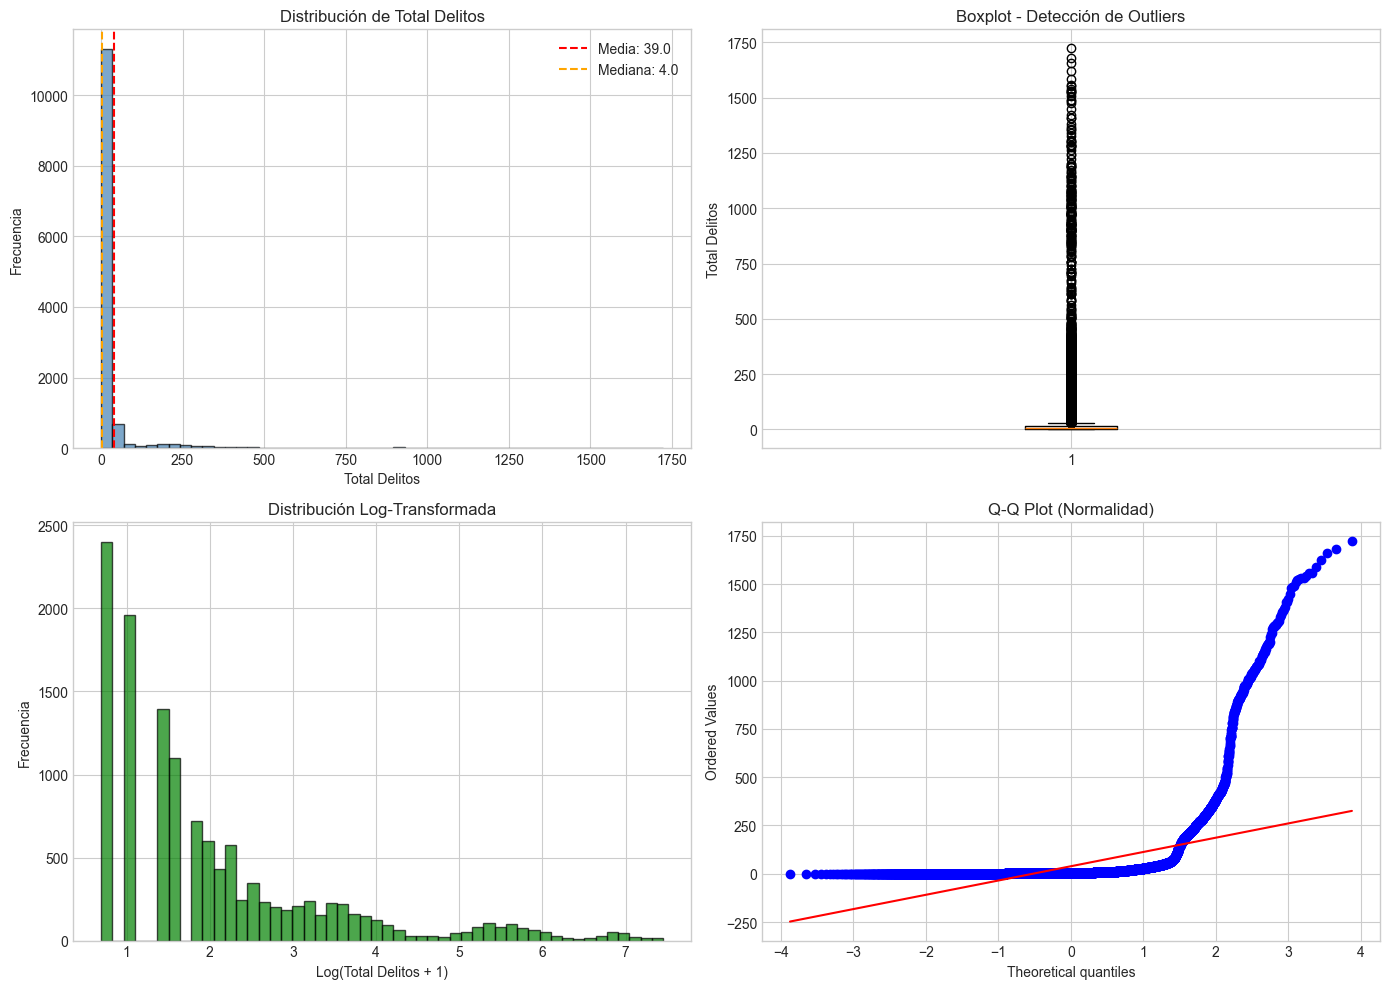


 Outliers detectados (IQR): 2008 (15.4%)


In [4]:
# 2.1 Distribución de la variable objetivo
print("=" * 60)
print("ANÁLISIS DE LA VARIABLE OBJETIVO: total_delitos")
print("=" * 60)

target = 'total_delitos'

# Estadísticas descriptivas
print(f"\n Estadísticas descriptivas:")
print(df[target].describe())

# Asimetría y curtosis
skewness = df[target].skew()
kurtosis = df[target].kurtosis()
print(f"\n Asimetría (skewness): {skewness:.3f}")
print(f" Curtosis: {kurtosis:.3f}")

if skewness > 1:
    print("   ⚠️ Distribución muy asimétrica positiva - considerar transformación log")
elif skewness < -1:
    print("   ⚠️ Distribución muy asimétrica negativa")
else:
    print("   ✅ Asimetría moderada")

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histograma
ax1 = axes[0, 0]
ax1.hist(df[target], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(df[target].mean(), color='red', linestyle='--', label=f'Media: {df[target].mean():.1f}')
ax1.axvline(df[target].median(), color='orange', linestyle='--', label=f'Mediana: {df[target].median():.1f}')
ax1.set_xlabel('Total Delitos')
ax1.set_ylabel('Frecuencia')
ax1.set_title('Distribución de Total Delitos')
ax1.legend()

# Boxplot
ax2 = axes[0, 1]
ax2.boxplot(df[target], vert=True)
ax2.set_ylabel('Total Delitos')
ax2.set_title('Boxplot - Detección de Outliers')

# Distribución log
ax3 = axes[1, 0]
df_log = np.log1p(df[target])
ax3.hist(df_log, bins=50, edgecolor='black', alpha=0.7, color='green')
ax3.set_xlabel('Log(Total Delitos + 1)')
ax3.set_ylabel('Frecuencia')
ax3.set_title('Distribución Log-Transformada')

# QQ-Plot
ax4 = axes[1, 1]
stats.probplot(df[target], dist="norm", plot=ax4)
ax4.set_title('Q-Q Plot (Normalidad)')

plt.tight_layout()
plt.show()

# Outliers usando IQR
Q1 = df[target].quantile(0.25)
Q3 = df[target].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df[target] < Q1 - 1.5*IQR) | (df[target] > Q3 + 1.5*IQR)]
print(f"\n Outliers detectados (IQR): {len(outliers)} ({len(outliers)/len(df)*100:.1f}%)")

EVOLUCIÓN TEMPORAL DE DELITOS


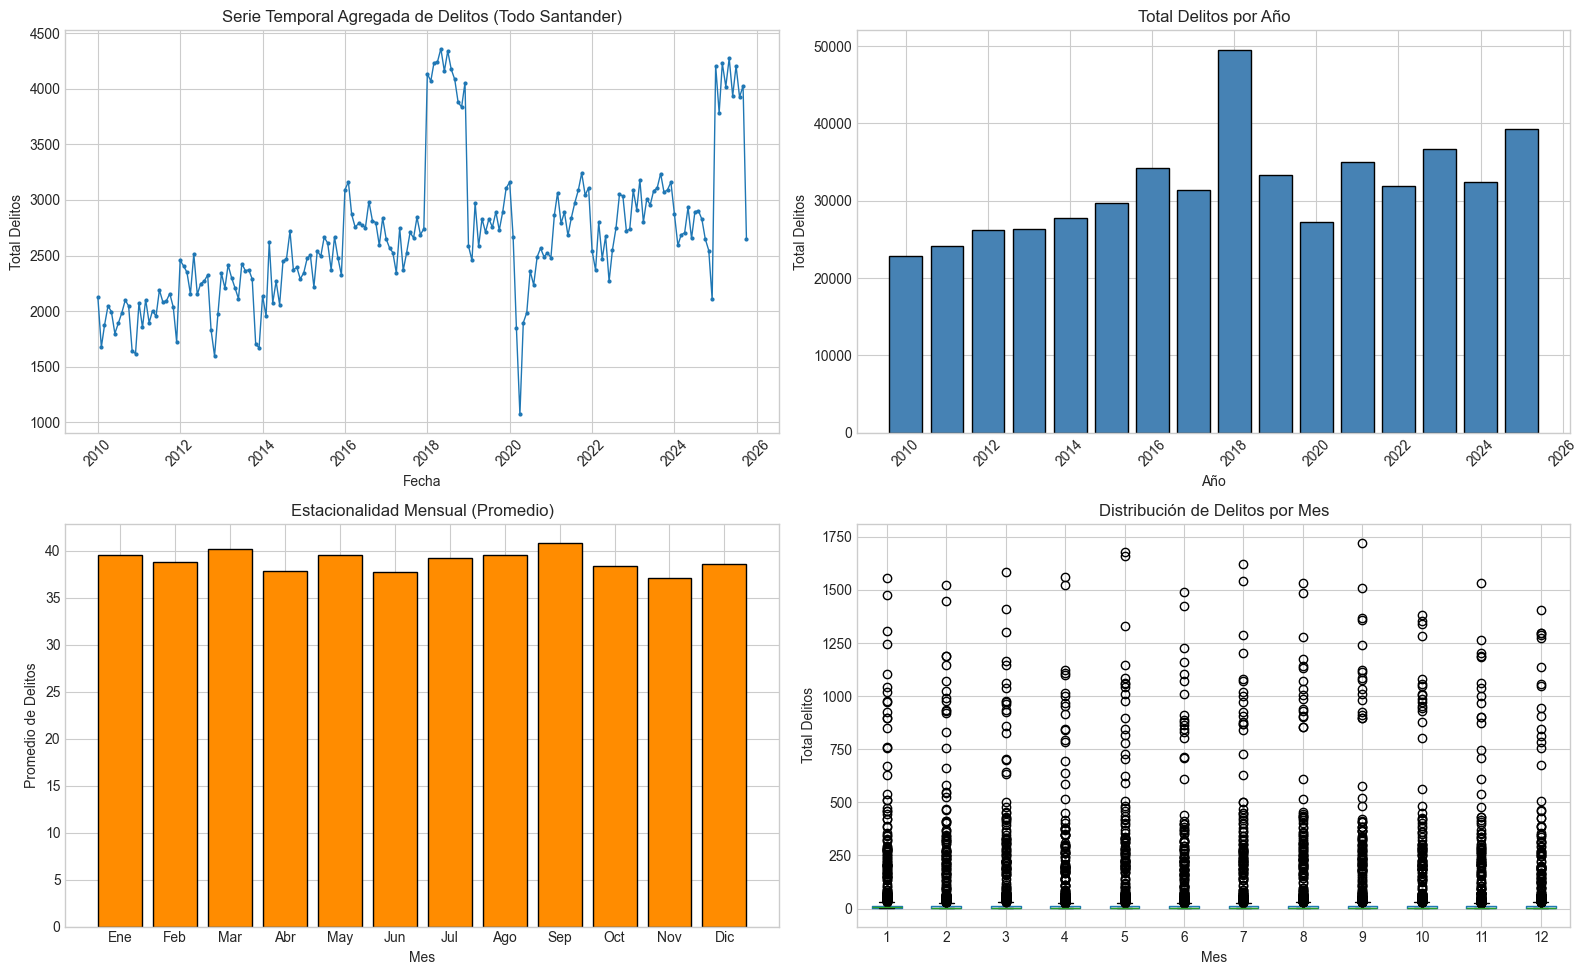


 Meses con más delitos (promedio):
   Mes 9: 40.8 delitos/municipio
   Mes 3: 40.2 delitos/municipio
   Mes 1: 39.6 delitos/municipio

 Meses con menos delitos (promedio):
   Mes 11: 37.1 delitos/municipio
   Mes 6: 37.7 delitos/municipio
   Mes 4: 37.8 delitos/municipio


In [5]:
# 2.2 Evolución temporal de delitos
print("=" * 60)
print("EVOLUCIÓN TEMPORAL DE DELITOS")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Serie temporal agregada por mes
df_temporal = df.groupby(['anio', 'mes'])[target].sum().reset_index()
df_temporal['fecha'] = pd.to_datetime(df_temporal['anio'].astype(str) + '-' + df_temporal['mes'].astype(str) + '-01')

ax1 = axes[0, 0]
ax1.plot(df_temporal['fecha'], df_temporal[target], marker='o', markersize=2, linewidth=1)
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Total Delitos')
ax1.set_title('Serie Temporal Agregada de Delitos (Todo Santander)')
ax1.tick_params(axis='x', rotation=45)

# Tendencia por año
ax2 = axes[0, 1]
delitos_por_anio = df.groupby('anio')[target].sum()
bars = ax2.bar(delitos_por_anio.index, delitos_por_anio.values, color='steelblue', edgecolor='black')
ax2.set_xlabel('Año')
ax2.set_ylabel('Total Delitos')
ax2.set_title('Total Delitos por Año')
ax2.tick_params(axis='x', rotation=45)

# Estacionalidad mensual
ax3 = axes[1, 0]
delitos_por_mes = df.groupby('mes')[target].mean()
bars = ax3.bar(delitos_por_mes.index, delitos_por_mes.values, color='darkorange', edgecolor='black')
ax3.set_xlabel('Mes')
ax3.set_ylabel('Promedio de Delitos')
ax3.set_title('Estacionalidad Mensual (Promedio)')
ax3.set_xticks(range(1, 13))
ax3.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
                     'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])

# Boxplot por mes
ax4 = axes[1, 1]
df.boxplot(column=target, by='mes', ax=ax4)
ax4.set_xlabel('Mes')
ax4.set_ylabel('Total Delitos')
ax4.set_title('Distribución de Delitos por Mes')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Análisis de estacionalidad
print("\n Meses con más delitos (promedio):")
top_meses = delitos_por_mes.sort_values(ascending=False).head(3)
for mes, val in top_meses.items():
    print(f"   Mes {mes}: {val:.1f} delitos/municipio")

print("\n Meses con menos delitos (promedio):")
bottom_meses = delitos_por_mes.sort_values().head(3)
for mes, val in bottom_meses.items():
    print(f"   Mes {mes}: {val:.1f} delitos/municipio")

---
## 3. Análisis de Correlaciones y Features

ANÁLISIS DE CORRELACIONES

 Top 15 correlaciones con 'total_delitos':
   🟢 roll_mean_3: 0.995
   🟢 lag_1: 0.987
   🟢 roll_mean_12: 0.983
   🟢 lag_3: 0.977
   🟢 lag_12: 0.958
   🟢 HURTOS: 0.948
   🟢 n_dias_semana: 0.947
   🟢 n_dias_laborales: 0.945
   🟢 femenino_adolescentes: 0.938
   🟢 poblacion_adolescentes: 0.938
   🟢 masculino_adolescentes: 0.937
   🟢 VIOLENCIA INTRAFAMILIAR: 0.933
   🟢 femenino_menores: 0.932
   🟢 poblacion_menores: 0.932
   🟢 masculino_menores: 0.932


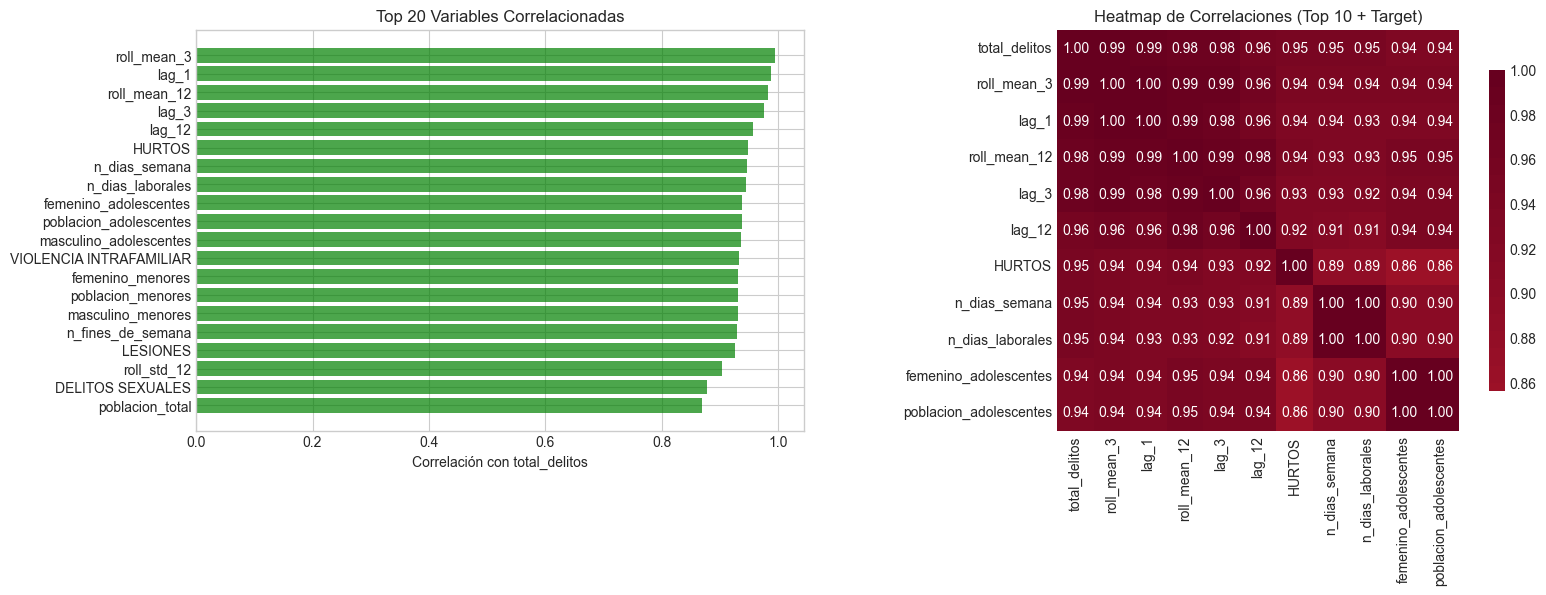

In [6]:
# 3.1 Correlaciones con la variable objetivo
print("=" * 60)
print("ANÁLISIS DE CORRELACIONES")
print("=" * 60)

# Seleccionar solo columnas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Excluir columnas no relevantes
exclude_cols = ['codigo_departamento', 'Shape_Leng', 'Shape_Area']
numeric_cols = [c for c in numeric_cols if c not in exclude_cols]

# Calcular correlaciones con el target
correlations = df[numeric_cols].corr()[target].drop(target).sort_values(key=abs, ascending=False)

print(f"\n Top 15 correlaciones con '{target}':")
for col, corr in correlations.head(15).items():
    emoji = "🟢" if corr > 0.5 else ("🟡" if corr > 0.3 else "⚪")
    print(f"   {emoji} {col}: {corr:.3f}")

# Visualización de correlaciones
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top correlaciones
ax1 = axes[0]
top_corr = correlations.head(20)
colors = ['green' if c > 0 else 'red' for c in top_corr.values]
ax1.barh(top_corr.index, top_corr.values, color=colors, alpha=0.7)
ax1.axvline(x=0, color='black', linewidth=0.5)
ax1.set_xlabel('Correlación con total_delitos')
ax1.set_title('Top 20 Variables Correlacionadas')
ax1.invert_yaxis()

# Heatmap de variables más importantes
ax2 = axes[1]
important_vars = [target] + correlations.head(10).index.tolist()
corr_matrix = df[important_vars].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0, 
            ax=ax2, square=True, cbar_kws={'shrink': 0.8})
ax2.set_title('Heatmap de Correlaciones (Top 10 + Target)')

plt.tight_layout()
plt.show()

ANÁLISIS DE LAG FEATURES


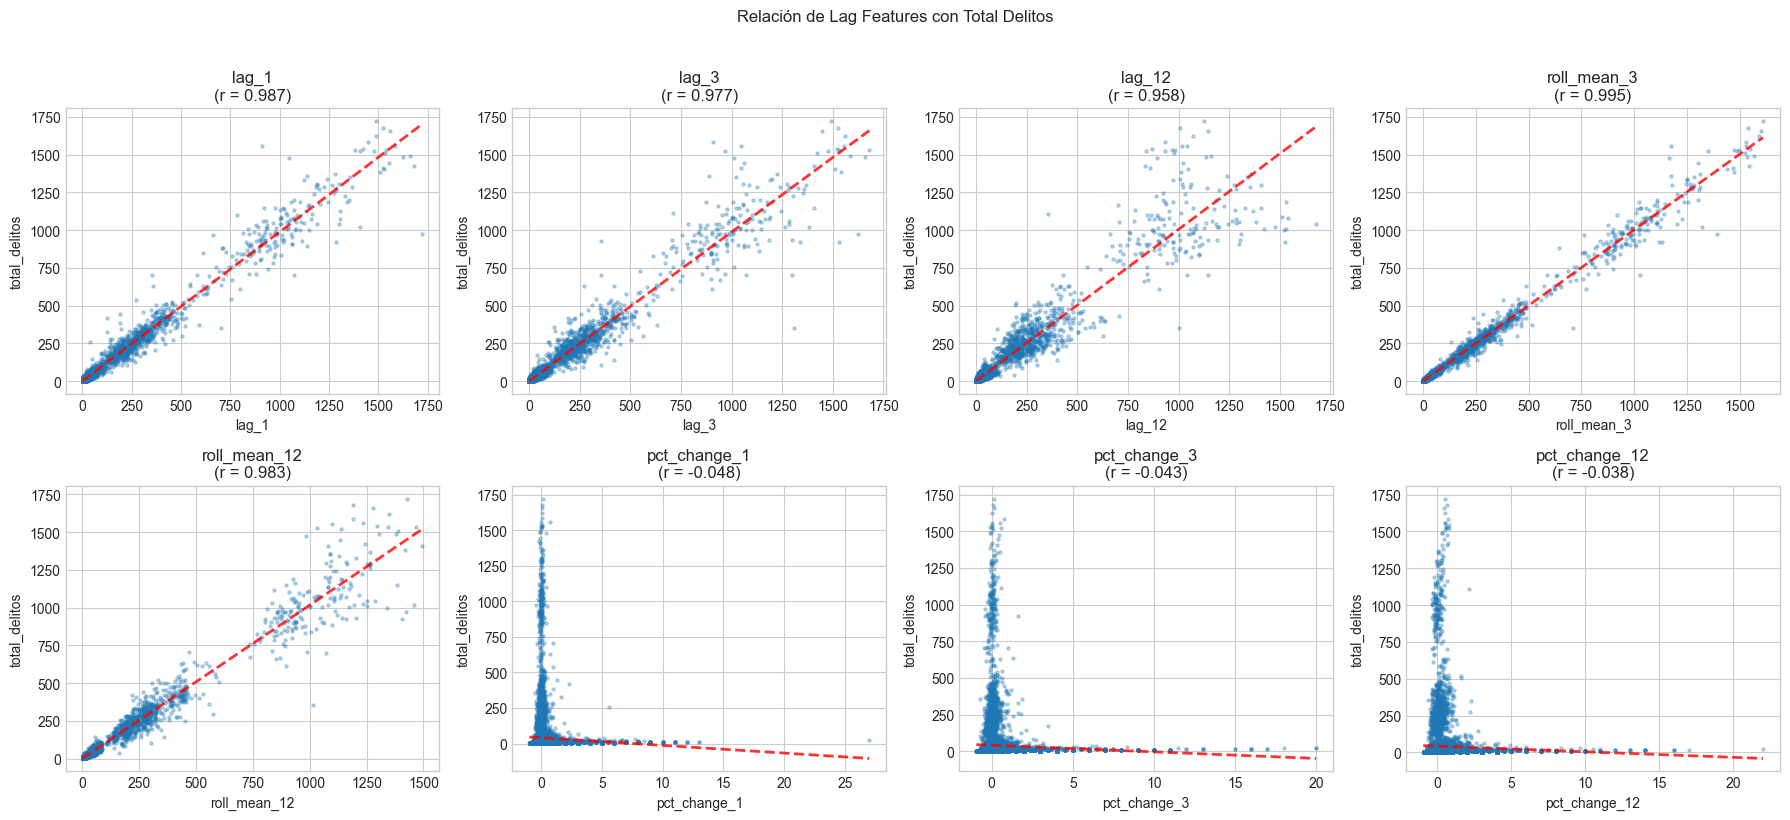


 Conclusión sobre Lag Features:
   • lag_1 y roll_mean_3 suelen ser los más predictivos
   • lag_12 captura estacionalidad anual
   • pct_change captura tendencias de cambio


In [7]:
# 3.2 Análisis de Lag Features (importantes para series temporales)
print("=" * 60)
print("ANÁLISIS DE LAG FEATURES")
print("=" * 60)

lag_cols = ['lag_1', 'lag_3', 'lag_12', 'roll_mean_3', 'roll_mean_12', 
            'pct_change_1', 'pct_change_3', 'pct_change_12']

fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(lag_cols):
    ax = axes[i]
    # Filtrar valores no nulos
    mask = ~df[col].isna() & ~df[target].isna()
    if mask.sum() > 0:
        ax.scatter(df.loc[mask, col], df.loc[mask, target], alpha=0.3, s=5)
        
        # Línea de regresión
        z = np.polyfit(df.loc[mask, col], df.loc[mask, target], 1)
        p = np.poly1d(z)
        x_line = np.linspace(df.loc[mask, col].min(), df.loc[mask, col].max(), 100)
        ax.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2)
        
        corr = df.loc[mask, [col, target]].corr().iloc[0, 1]
        ax.set_title(f'{col}\n(r = {corr:.3f})')
    ax.set_xlabel(col)
    ax.set_ylabel(target)

plt.suptitle('Relación de Lag Features con Total Delitos', y=1.02)
plt.tight_layout()
plt.show()

print("\n Conclusión sobre Lag Features:")
print("   • lag_1 y roll_mean_3 suelen ser los más predictivos")
print("   • lag_12 captura estacionalidad anual")
print("   • pct_change captura tendencias de cambio")

---
## 4. Preprocesamiento de Datos

Manejamos valores nulos y preparamos los datos para el modelado.

In [8]:
# 4.1 Manejo de valores nulos
print("=" * 60)
print("PREPROCESAMIENTO DE DATOS")
print("=" * 60)

# Crear copia para procesamiento
df_model = df.copy()

# Verificar valores nulos
nulls_before = df_model.isnull().sum()
print(f"\n Valores nulos antes del procesamiento:")
print(nulls_before[nulls_before > 0])

# Estrategia 1: Eliminar filas donde lag_12 es nulo (primer año de cada municipio)
# Esto es aceptable porque necesitamos historia para predecir
print(f"\n Estrategia: Eliminar filas sin suficiente historia temporal")
print(f"   Registros antes: {len(df_model):,}")

# Identificar columnas con nulos de lag (son por diseño, no aleatorios)
lag_null_cols = ['lag_1', 'lag_3', 'lag_12', 'roll_mean_3', 'roll_mean_12', 
                 'roll_std_3', 'roll_std_12', 'pct_change_1', 'pct_change_3', 'pct_change_12']

# Opción A: Eliminar filas con cualquier nulo en lags (más estricto)
# df_model = df_model.dropna(subset=lag_null_cols)

# Opción B: Eliminar solo filas donde lag_12 es nulo (mantiene más datos)
df_model = df_model.dropna(subset=['lag_12'])

print(f"   Registros después: {len(df_model):,}")
print(f"   Eliminados: {len(df) - len(df_model):,} ({(len(df) - len(df_model))/len(df)*100:.1f}%)")

# Verificar que no queden nulos
nulls_after = df_model.isnull().sum()
if nulls_after.sum() > 0:
    print(f"\n⚠️ Aún hay nulos, rellenando con la mediana por municipio:")
    # Rellenar nulos restantes con la mediana del municipio
    for col in nulls_after[nulls_after > 0].index:
        df_model[col] = df_model.groupby('codigo_municipio')[col].transform(
            lambda x: x.fillna(x.median())
        )
        # Si aún hay nulos, usar la mediana global
        df_model[col] = df_model[col].fillna(df_model[col].median())
    
    print(f"   Nulos después de rellenar: {df_model.isnull().sum().sum()}")
else:
    print(f"\n✅ No quedan valores nulos")

PREPROCESAMIENTO DE DATOS

 Valores nulos antes del procesamiento:
lag_1              87
lag_3             261
lag_12           1044
roll_mean_3       174
roll_mean_12      957
roll_std_3        174
roll_std_12       957
pct_change_1       87
pct_change_3      261
pct_change_12    1044
dtype: int64

 Estrategia: Eliminar filas sin suficiente historia temporal
   Registros antes: 13,044
   Registros después: 12,000
   Eliminados: 1,044 (8.0%)

✅ No quedan valores nulos


In [9]:
# 4.2 Selección y preparación de features
print("=" * 60)
print("SELECCIÓN DE FEATURES")
print("=" * 60)

# Definir features a usar
feature_cols = [
    # Temporales
    'anio', 'mes', 'trimestre',
    # Estacionalidad codificada
    'mes_sin', 'mes_cos',
    # Características del mes
    'n_dias_laborales', 'n_fines_de_semana', 'n_festivos', 'es_fin_ano',
    # Geográficas
    'codigo_municipio', 'area_km2', 'densidad_poblacional', 'n_centros_poblados',
    # Demográficas
    'poblacion_total', 'proporcion_menores', 'proporcion_adultos', 'proporcion_adolescentes',
    # Lag features (MUY IMPORTANTES para regresión temporal)
    'lag_1', 'lag_3', 'lag_12',
    # Rolling statistics
    'roll_mean_3', 'roll_mean_12', 'roll_std_3', 'roll_std_12',
    # Cambios porcentuales
    'pct_change_1', 'pct_change_3', 'pct_change_12'
]

# Verificar que todas las columnas existen
feature_cols = [c for c in feature_cols if c in df_model.columns]
print(f"\n✅ Features seleccionados: {len(feature_cols)}")
for i, col in enumerate(feature_cols, 1):
    print(f"   {i:2}. {col}")

# Preparar X e y
X = df_model[feature_cols].copy()
y = df_model[target].copy()

print(f"\n Shapes:")
print(f"   X: {X.shape}")
print(f"   y: {y.shape}")

SELECCIÓN DE FEATURES

✅ Features seleccionados: 27
    1. anio
    2. mes
    3. trimestre
    4. mes_sin
    5. mes_cos
    6. n_dias_laborales
    7. n_fines_de_semana
    8. n_festivos
    9. es_fin_ano
   10. codigo_municipio
   11. area_km2
   12. densidad_poblacional
   13. n_centros_poblados
   14. poblacion_total
   15. proporcion_menores
   16. proporcion_adultos
   17. proporcion_adolescentes
   18. lag_1
   19. lag_3
   20. lag_12
   21. roll_mean_3
   22. roll_mean_12
   23. roll_std_3
   24. roll_std_12
   25. pct_change_1
   26. pct_change_3
   27. pct_change_12

 Shapes:
   X: (12000, 27)
   y: (12000,)


In [10]:
# 4.3 División temporal de datos (IMPORTANTE: no usar random split para series temporales)
from sklearn.preprocessing import StandardScaler

print("=" * 60)
print("DIVISIÓN TEMPORAL DE DATOS")
print("=" * 60)

# División temporal: usar los últimos 2 años para test
YEAR_SPLIT = 2023
mask_train = df_model['anio'] < YEAR_SPLIT
mask_test = df_model['anio'] >= YEAR_SPLIT

X_train = X[mask_train].copy()
X_test = X[mask_test].copy()
y_train = y[mask_train].copy()
y_test = y[mask_test].copy()

print(f"\n✅ División temporal (antes/después de {YEAR_SPLIT}):")
print(f"   Train: {len(X_train):,} muestras ({len(X_train)/len(X)*100:.1f}%) - Años {df_model.loc[mask_train, 'anio'].min()}-{df_model.loc[mask_train, 'anio'].max()}")
print(f"   Test:  {len(X_test):,} muestras ({len(X_test)/len(X)*100:.1f}%) - Años {df_model.loc[mask_test, 'anio'].min()}-{df_model.loc[mask_test, 'anio'].max()}")

# Escalar features (importante para algunos modelos)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Features escalados con StandardScaler")
print(f"   Media train: {X_train_scaled.mean():.6f}")
print(f"   Std train: {X_train_scaled.std():.6f}")

DIVISIÓN TEMPORAL DE DATOS

✅ División temporal (antes/después de 2023):
   Train: 9,657 muestras (80.5%) - Años 2011-2022
   Test:  2,343 muestras (19.5%) - Años 2023-2025

✅ Features escalados con StandardScaler
   Media train: 0.000000
   Std train: 1.000000


---
## 5. Modelado: Comparación de Algoritmos

Probamos múltiples algoritmos de regresión para identificar el mejor.

In [11]:
# 5.1 Entrenamiento de múltiples modelos
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("=" * 60)
print("ENTRENAMIENTO DE MODELOS DE REGRESIÓN")
print("=" * 60)

# Definir modelos
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=0.1, random_state=42),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
    'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, verbosity=0)
}

# Almacenar resultados
results = {}

for name, model in models.items():
    print(f"\n {name}...")
    
    # Usar datos escalados para modelos lineales
    if name in ['Linear Regression', 'Ridge', 'Lasso', 'ElasticNet']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Calcular métricas
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1))) * 100  # +1 para evitar división por cero
    
    results[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape,
        'model': model
    }
    
    print(f"   MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.4f} | MAPE: {mape:.1f}%")

ENTRENAMIENTO DE MODELOS DE REGRESIÓN

 Linear Regression...
   MAE: 4.41 | RMSE: 12.94 | R²: 0.9941 | MAPE: 29.1%

 Ridge...
   MAE: 4.39 | RMSE: 12.99 | R²: 0.9940 | MAPE: 28.6%

 Lasso...
   MAE: 4.24 | RMSE: 13.48 | R²: 0.9936 | MAPE: 26.2%

 ElasticNet...
   MAE: 5.49 | RMSE: 20.52 | R²: 0.9851 | MAPE: 28.8%

 Decision Tree...
   MAE: 4.71 | RMSE: 23.74 | R²: 0.9801 | MAPE: 12.0%

 Random Forest...
   MAE: 3.39 | RMSE: 19.70 | R²: 0.9863 | MAPE: 6.2%

 Gradient Boosting...
   MAE: 3.32 | RMSE: 17.31 | R²: 0.9894 | MAPE: 8.3%

 XGBoost...
   MAE: 3.99 | RMSE: 22.75 | R²: 0.9817 | MAPE: 8.1%


RESUMEN DE RESULTADOS

 Comparación de modelos (ordenado por MAE):
           Modelo      MAE      RMSE       R²  MAPE (%)
Gradient Boosting 3.322023 17.306360 0.989417  8.276562
    Random Forest 3.389500 19.703080 0.986282  6.227038
          XGBoost 3.988839 22.750506 0.981711  8.078439
            Lasso 4.240656 13.478603 0.993580 26.196136
            Ridge 4.387883 12.990905 0.994037 28.639234
Linear Regression 4.408512 12.944016 0.994080 29.097366
    Decision Tree 4.713627 23.743087 0.980080 12.041927
       ElasticNet 5.492129 20.520765 0.985120 28.827364

 Mejor modelo: Gradient Boosting
   MAE: 3.32 delitos
   RMSE: 17.31 delitos
   R²: 0.9894
   MAPE: 8.3%


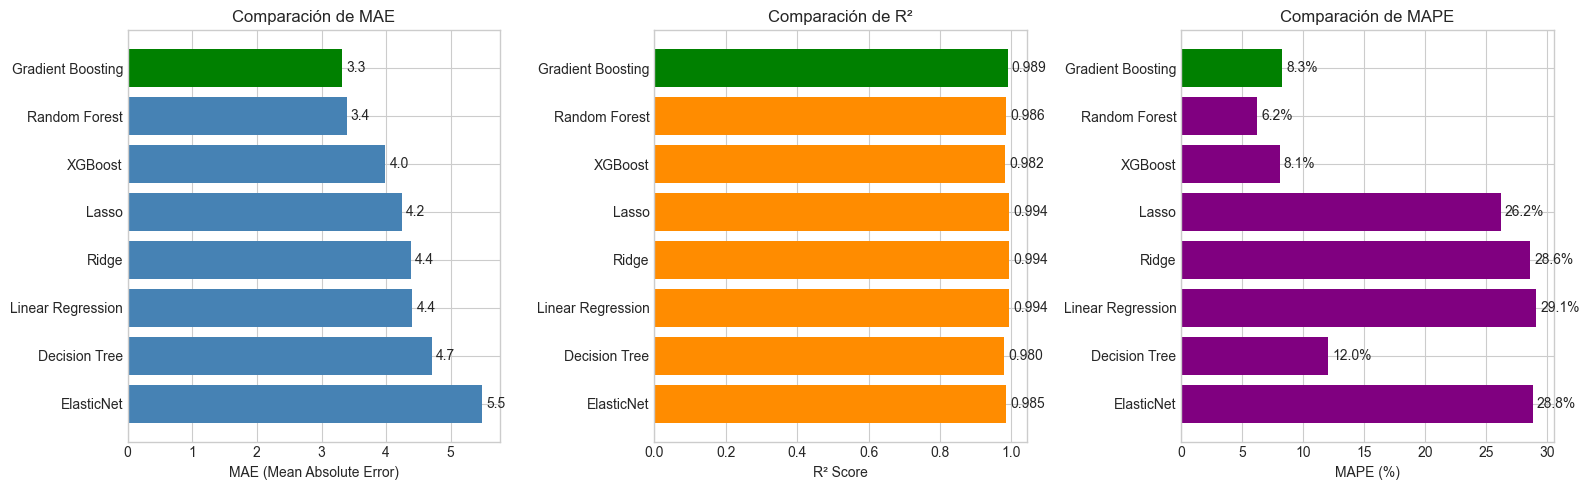

In [12]:
# 5.2 Comparación de resultados
print("=" * 60)
print("RESUMEN DE RESULTADOS")
print("=" * 60)

# Crear DataFrame de comparación
comparison_df = pd.DataFrame({
    'Modelo': list(results.keys()),
    'MAE': [r['MAE'] for r in results.values()],
    'RMSE': [r['RMSE'] for r in results.values()],
    'R²': [r['R2'] for r in results.values()],
    'MAPE (%)': [r['MAPE'] for r in results.values()]
}).sort_values('MAE')

print("\n Comparación de modelos (ordenado por MAE):")
print(comparison_df.to_string(index=False))

# Identificar mejor modelo
best_model_name = comparison_df.iloc[0]['Modelo']
best_result = results[best_model_name]

print(f"\n Mejor modelo: {best_model_name}")
print(f"   MAE: {best_result['MAE']:.2f} delitos")
print(f"   RMSE: {best_result['RMSE']:.2f} delitos")
print(f"   R²: {best_result['R2']:.4f}")
print(f"   MAPE: {best_result['MAPE']:.1f}%")

# Visualización
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# MAE
ax1 = axes[0]
colors = ['green' if m == best_model_name else 'steelblue' for m in comparison_df['Modelo']]
bars = ax1.barh(comparison_df['Modelo'], comparison_df['MAE'], color=colors)
ax1.set_xlabel('MAE (Mean Absolute Error)')
ax1.set_title('Comparación de MAE')
ax1.bar_label(bars, fmt='%.1f', padding=3)
ax1.invert_yaxis()

# R²
ax2 = axes[1]
colors = ['green' if m == best_model_name else 'darkorange' for m in comparison_df['Modelo']]
bars = ax2.barh(comparison_df['Modelo'], comparison_df['R²'], color=colors)
ax2.set_xlabel('R² Score')
ax2.set_title('Comparación de R²')
ax2.bar_label(bars, fmt='%.3f', padding=3)
ax2.invert_yaxis()

# MAPE
ax3 = axes[2]
colors = ['green' if m == best_model_name else 'purple' for m in comparison_df['Modelo']]
bars = ax3.barh(comparison_df['Modelo'], comparison_df['MAPE (%)'], color=colors)
ax3.set_xlabel('MAPE (%)')
ax3.set_title('Comparación de MAPE')
ax3.bar_label(bars, fmt='%.1f%%', padding=3)
ax3.invert_yaxis()

plt.tight_layout()
plt.show()

---
## 6. Evaluación Detallada del Mejor Modelo

EVALUACIÓN DETALLADA DEL MEJOR MODELO


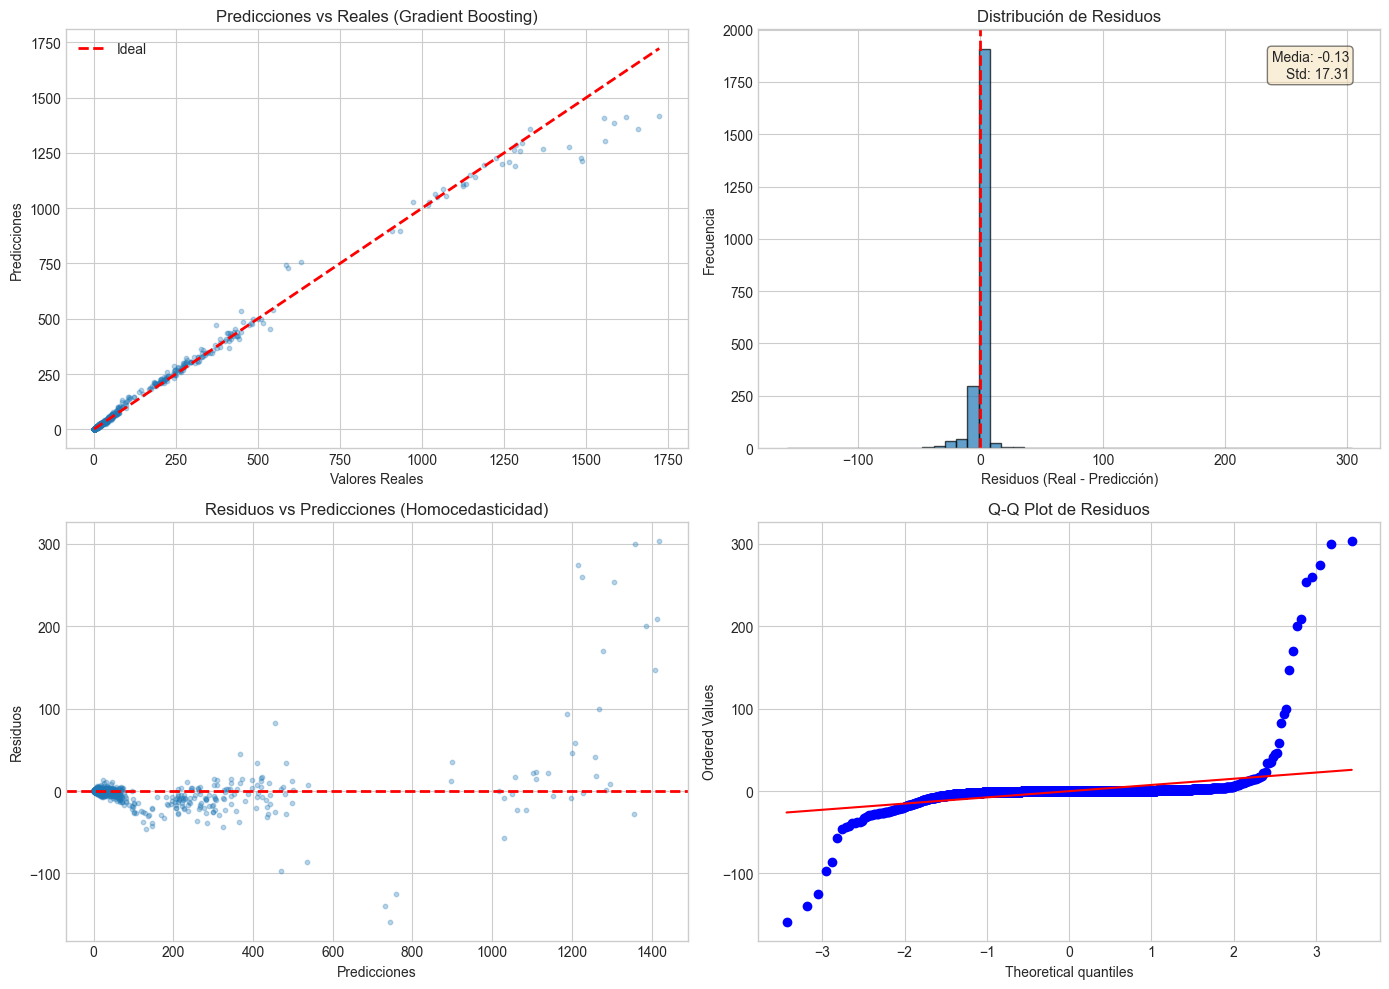


 Análisis de Residuos:
   Media: -0.125 (ideal: 0)
   Std: 17.306
   Min: -158.5 | Max: 303.7


In [13]:
# 6.1 Predicciones vs Valores Reales
print("=" * 60)
print("EVALUACIÓN DETALLADA DEL MEJOR MODELO")
print("=" * 60)

# Obtener predicciones del mejor modelo
best_model = results[best_model_name]['model']
if best_model_name in ['Linear Regression', 'Ridge', 'Lasso', 'ElasticNet']:
    y_pred_best = best_model.predict(X_test_scaled)
else:
    y_pred_best = best_model.predict(X_test)

# Visualización de predicciones
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Predicciones vs Valores Reales (scatter)
ax1 = axes[0, 0]
ax1.scatter(y_test, y_pred_best, alpha=0.3, s=10)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Ideal')
ax1.set_xlabel('Valores Reales')
ax1.set_ylabel('Predicciones')
ax1.set_title(f'Predicciones vs Reales ({best_model_name})')
ax1.legend()

# 2. Distribución de residuos
ax2 = axes[0, 1]
residuos = y_test.values - y_pred_best
ax2.hist(residuos, bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(0, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Residuos (Real - Predicción)')
ax2.set_ylabel('Frecuencia')
ax2.set_title('Distribución de Residuos')
ax2.annotate(f'Media: {residuos.mean():.2f}\nStd: {residuos.std():.2f}', 
             xy=(0.95, 0.95), xycoords='axes fraction', ha='right', va='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 3. Residuos vs Predicciones
ax3 = axes[1, 0]
ax3.scatter(y_pred_best, residuos, alpha=0.3, s=10)
ax3.axhline(0, color='red', linestyle='--', linewidth=2)
ax3.set_xlabel('Predicciones')
ax3.set_ylabel('Residuos')
ax3.set_title('Residuos vs Predicciones (Homocedasticidad)')

# 4. QQ-Plot de residuos
ax4 = axes[1, 1]
stats.probplot(residuos, dist="norm", plot=ax4)
ax4.set_title('Q-Q Plot de Residuos')

plt.tight_layout()
plt.show()

# Estadísticas de residuos
print(f"\n Análisis de Residuos:")
print(f"   Media: {residuos.mean():.3f} (ideal: 0)")
print(f"   Std: {residuos.std():.3f}")
print(f"   Min: {residuos.min():.1f} | Max: {residuos.max():.1f}")

IMPORTANCIA DE FEATURES


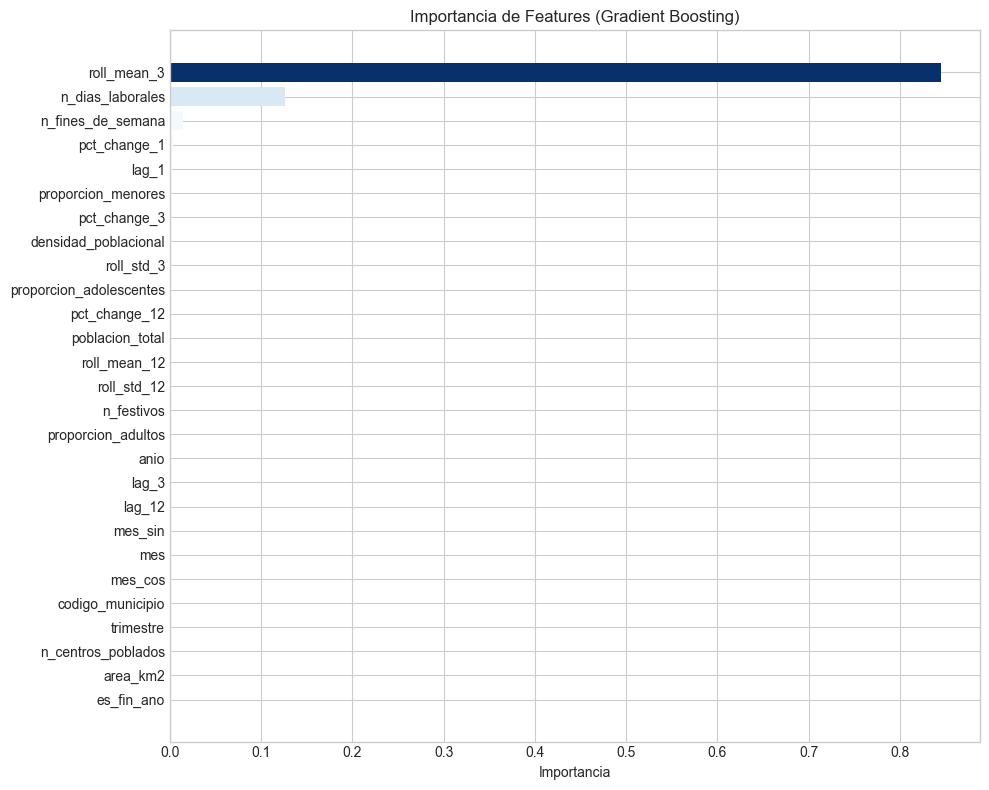


 Top 10 Features más importantes:
   roll_mean_3: 0.8457
   n_dias_laborales: 0.1266
   n_fines_de_semana: 0.0148
   pct_change_1: 0.0034
   lag_1: 0.0023
   proporcion_menores: 0.0016
   pct_change_3: 0.0013
   densidad_poblacional: 0.0008
   roll_std_3: 0.0006
   proporcion_adolescentes: 0.0006


In [14]:
# 6.2 Importancia de Features
print("=" * 60)
print("IMPORTANCIA DE FEATURES")
print("=" * 60)

# Obtener importancia de features (si el modelo lo soporta)
if hasattr(best_model, 'feature_importances_'):
    importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=True)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    colors = plt.cm.Blues(importance['importance'] / importance['importance'].max())
    ax.barh(importance['feature'], importance['importance'], color=colors)
    ax.set_xlabel('Importancia')
    ax.set_title(f'Importancia de Features ({best_model_name})')
    plt.tight_layout()
    plt.show()
    
    print("\n Top 10 Features más importantes:")
    for _, row in importance.tail(10).iloc[::-1].iterrows():
        print(f"   {row['feature']}: {row['importance']:.4f}")

elif hasattr(best_model, 'coef_'):
    # Para modelos lineales
    importance = pd.DataFrame({
        'feature': feature_cols,
        'coefficient': np.abs(best_model.coef_)
    }).sort_values('coefficient', ascending=True)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    colors = ['green' if c > 0 else 'red' for c in best_model.coef_[np.argsort(np.abs(best_model.coef_))]]
    ax.barh(importance['feature'], importance['coefficient'], color=colors)
    ax.set_xlabel('|Coeficiente|')
    ax.set_title(f'Coeficientes del Modelo ({best_model_name})')
    plt.tight_layout()
    plt.show()
    
    print("\n Top 10 Features con mayor coeficiente:")
    for _, row in importance.tail(10).iloc[::-1].iterrows():
        print(f"   {row['feature']}: {row['coefficient']:.4f}")

---
## 7. Optimización de Hiperparámetros

Optimizamos el modelo XGBoost para mejorar el rendimiento.

In [15]:
# 7.1 RandomizedSearchCV para XGBoost
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import randint, uniform

print("=" * 60)
print("OPTIMIZACIÓN DE HIPERPARÁMETROS - XGBoost")
print("=" * 60)

# Espacio de búsqueda
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

# Usar TimeSeriesSplit para validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=3)

xgb_model = XGBRegressor(random_state=42, verbosity=0)

random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=30,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("\n Buscando mejores hiperparámetros...")
random_search.fit(X_train, y_train)

print(f"\n✅ Mejores hiperparámetros encontrados:")
for param, value in random_search.best_params_.items():
    if isinstance(value, float):
        print(f"   {param}: {value:.4f}")
    else:
        print(f"   {param}: {value}")

print(f"\n Mejor MAE (CV): {-random_search.best_score_:.2f}")

OPTIMIZACIÓN DE HIPERPARÁMETROS - XGBoost

 Buscando mejores hiperparámetros...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

✅ Mejores hiperparámetros encontrados:
   colsample_bytree: 0.7425
   gamma: 0.4534
   learning_rate: 0.0916
   max_depth: 13
   min_child_weight: 9
   n_estimators: 165
   reg_alpha: 0.3526
   reg_lambda: 0.3048
   subsample: 0.6659

 Mejor MAE (CV): 1.58


COMPARACIÓN: MODELO BASE vs OPTIMIZADO

 XGBoost Base:
   MAE: 3.99 | RMSE: 22.75 | R²: 0.9817 | MAPE: 8.1%

 XGBoost Optimizado:
   MAE: 3.06 | RMSE: 16.23 | R²: 0.9907 | MAPE: 5.4%

 Mejora:
   MAE: 0.93 (+23.4%)
   R²: 0.0090 (+0.9%)


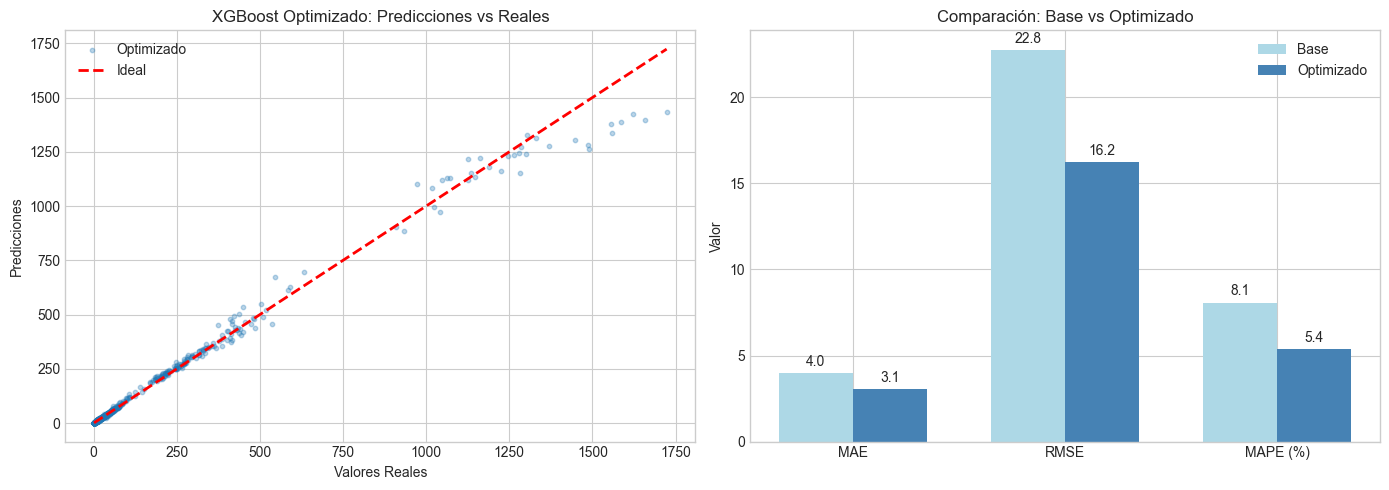

In [16]:
# 7.2 Evaluación del modelo optimizado vs base
print("=" * 60)
print("COMPARACIÓN: MODELO BASE vs OPTIMIZADO")
print("=" * 60)

# Predicciones con modelo optimizado
y_pred_opt = random_search.best_estimator_.predict(X_test)

# Métricas
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)
mape_opt = np.mean(np.abs((y_test - y_pred_opt) / (y_test + 1))) * 100

# Comparar con XGBoost base
xgb_base = results['XGBoost']

print(f"\n XGBoost Base:")
print(f"   MAE: {xgb_base['MAE']:.2f} | RMSE: {xgb_base['RMSE']:.2f} | R²: {xgb_base['R2']:.4f} | MAPE: {xgb_base['MAPE']:.1f}%")

print(f"\n XGBoost Optimizado:")
print(f"   MAE: {mae_opt:.2f} | RMSE: {rmse_opt:.2f} | R²: {r2_opt:.4f} | MAPE: {mape_opt:.1f}%")

print(f"\n Mejora:")
print(f"   MAE: {(xgb_base['MAE'] - mae_opt):.2f} ({(xgb_base['MAE'] - mae_opt)/xgb_base['MAE']*100:+.1f}%)")
print(f"   R²: {(r2_opt - xgb_base['R2']):.4f} ({(r2_opt - xgb_base['R2'])/abs(xgb_base['R2'])*100:+.1f}%)")

# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predicciones
ax1 = axes[0]
ax1.scatter(y_test, y_pred_opt, alpha=0.3, s=10, label='Optimizado')
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Ideal')
ax1.set_xlabel('Valores Reales')
ax1.set_ylabel('Predicciones')
ax1.set_title('XGBoost Optimizado: Predicciones vs Reales')
ax1.legend()

# Comparación de métricas
ax2 = axes[1]
metrics = ['MAE', 'RMSE', 'MAPE (%)']
base_vals = [xgb_base['MAE'], xgb_base['RMSE'], xgb_base['MAPE']]
opt_vals = [mae_opt, rmse_opt, mape_opt]

x = np.arange(len(metrics))
width = 0.35
bars1 = ax2.bar(x - width/2, base_vals, width, label='Base', color='lightblue')
bars2 = ax2.bar(x + width/2, opt_vals, width, label='Optimizado', color='steelblue')
ax2.set_ylabel('Valor')
ax2.set_title('Comparación: Base vs Optimizado')
ax2.set_xticks(x)
ax2.set_xticklabels(metrics)
ax2.legend()
ax2.bar_label(bars1, fmt='%.1f', padding=3)
ax2.bar_label(bars2, fmt='%.1f', padding=3)

plt.tight_layout()
plt.show()

IMPORTANCIA DE FEATURES - MODELO OPTIMIZADO


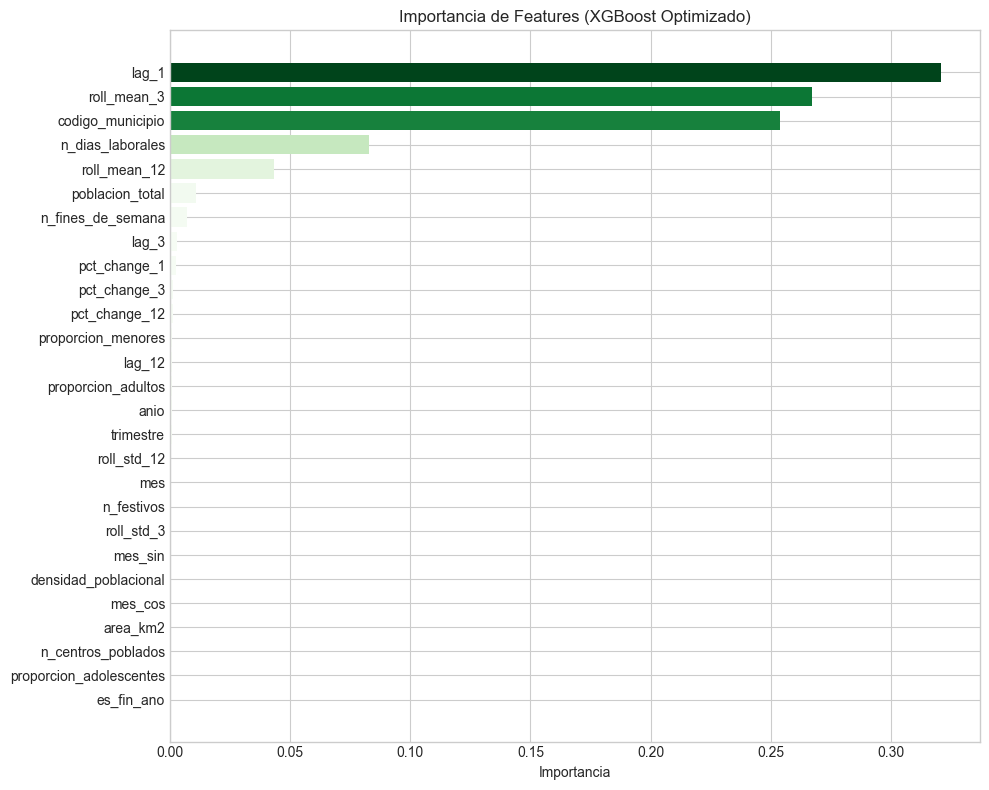


📊 Top 10 Features más importantes:
   lag_1: 0.3211
   roll_mean_3: 0.2671
   codigo_municipio: 0.2540
   n_dias_laborales: 0.0827
   roll_mean_12: 0.0432
   poblacion_total: 0.0109
   n_fines_de_semana: 0.0073
   lag_3: 0.0030
   pct_change_1: 0.0023
   pct_change_3: 0.0013


In [17]:
# 7.3 Importancia de Features - Modelo Optimizado
print("=" * 60)
print("IMPORTANCIA DE FEATURES - MODELO OPTIMIZADO")
print("=" * 60)

importance_opt = pd.DataFrame({
    'feature': feature_cols,
    'importance': random_search.best_estimator_.feature_importances_
}).sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
colors = plt.cm.Greens(importance_opt['importance'] / importance_opt['importance'].max())
ax.barh(importance_opt['feature'], importance_opt['importance'], color=colors)
ax.set_xlabel('Importancia')
ax.set_title('Importancia de Features (XGBoost Optimizado)')
plt.tight_layout()
plt.show()

print("\n📊 Top 10 Features más importantes:")
for _, row in importance_opt.tail(10).iloc[::-1].iterrows():
    print(f"   {row['feature']}: {row['importance']:.4f}")

---
## 8. Guardado del Modelo Final

In [18]:
# 8.1 Guardar modelo y artefactos
import joblib
import json

# Crear directorio
MODEL_NAME = 'regression_monthly'
MODELS_DIR = BASE_DIR / 'models' / 'predictivos' / MODEL_NAME
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Guardar modelo optimizado
joblib.dump(random_search.best_estimator_, MODELS_DIR / 'xgb_regressor.joblib')

# Guardar scaler
joblib.dump(scaler, MODELS_DIR / 'scaler.joblib')

# Guardar metadata
metadata = {
    'model_name': MODEL_NAME,
    'model_type': 'XGBRegressor',
    'created_at': pd.Timestamp.now().isoformat(),
    'features': feature_cols,
    'target': target,
    'best_params': {k: float(v) if isinstance(v, (np.floating, float)) else int(v) if isinstance(v, (np.integer, int)) else v 
                    for k, v in random_search.best_params_.items()},
    'metrics': {
        'MAE': float(mae_opt),
        'RMSE': float(rmse_opt),
        'R2': float(r2_opt),
        'MAPE': float(mape_opt)
    },
    'train_samples': int(len(X_train)),
    'test_samples': int(len(X_test)),
    'year_split': YEAR_SPLIT,
    'feature_importance': importance_opt.set_index('feature')['importance'].to_dict()
}

with open(MODELS_DIR / 'metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2, default=str)

print(f"✅ Modelo guardado en: {MODELS_DIR}")
print(f"\n Archivos guardados:")
for file in sorted(MODELS_DIR.iterdir()):
    print(f"   - {file.name}")

✅ Modelo guardado en: /Users/byverbel/quick_projects/Datos-al-Ecosistema/models/predictivos/regression_monthly

 Archivos guardados:
   - metadata.json
   - scaler.joblib
   - xgb_regressor.joblib


---
## 9. Ejemplo de Uso del Modelo

In [19]:
# 9.1 Ejemplo de uso del modelo
print("=" * 60)
print("EJEMPLO DE USO DEL MODELO")
print("=" * 60)

# Simular carga del modelo
modelo_cargado = joblib.load(MODELS_DIR / 'xgb_regressor.joblib')

# Tomar un ejemplo del test set
ejemplo_idx = 0
ejemplo_X = X_test.iloc[[ejemplo_idx]]
ejemplo_y_real = y_test.iloc[ejemplo_idx]

# Obtener info del municipio
ejemplo_info = df_model[mask_test].iloc[ejemplo_idx]

print(f"\n ENTRADA (Features del municipio-mes):")
print(f"   Municipio: {int(ejemplo_info['codigo_municipio'])}")
print(f"   Año-Mes: {int(ejemplo_info['anio'])}-{int(ejemplo_info['mes'])}")
print(f"   Población: {ejemplo_info['poblacion_total']:,.0f}")
print(f"   Delitos mes anterior (lag_1): {ejemplo_info['lag_1']:.0f}")
print(f"   Promedio últimos 3 meses: {ejemplo_info['roll_mean_3']:.1f}")

# Predicción
prediccion = modelo_cargado.predict(ejemplo_X)[0]

print(f"\n SALIDA:")
print(f"    Delitos predichos: {prediccion:.1f}")
print(f"    Delitos reales: {ejemplo_y_real:.0f}")
print(f"    Error: {abs(prediccion - ejemplo_y_real):.1f} delitos ({abs(prediccion - ejemplo_y_real)/ejemplo_y_real*100:.1f}%)")

EJEMPLO DE USO DEL MODELO

 ENTRADA (Features del municipio-mes):
   Municipio: 68001
   Año-Mes: 2023-1
   Población: 614,860
   Delitos mes anterior (lag_1): 1275
   Promedio últimos 3 meses: 1240.3

 SALIDA:
    Delitos predichos: 1230.0
    Delitos reales: 1245
    Error: 15.0 delitos (1.2%)
